In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylidc as pl
from project_config import env_config

nodule_df_path = env_config.nodule_df_file
nodule_processed_df_path = env_config.processed_nodule_df_file
hold_out_nodule_df_path = env_config.hold_out_nodule_df_file

plots_path = "report/plots"

## Distribution of annotations malignancy

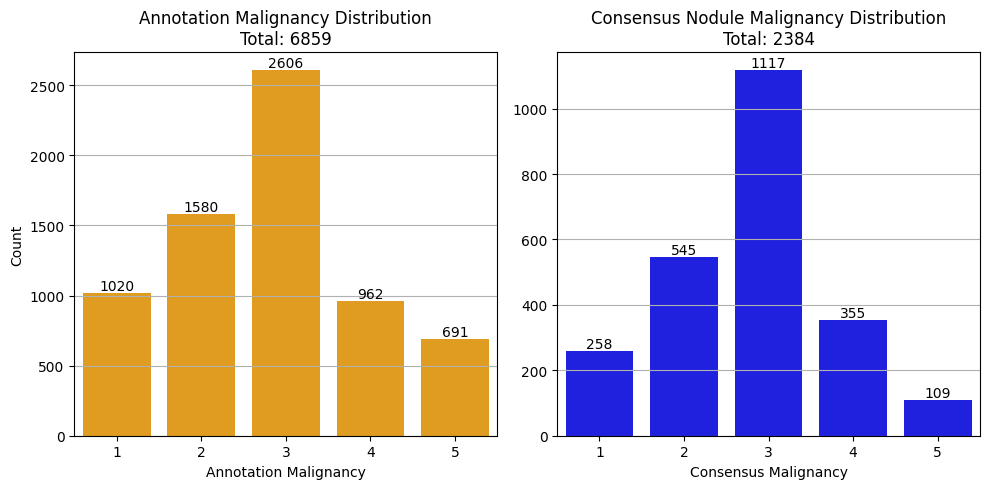

In [12]:
annotation_malignancy_counts = [
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 1).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 2).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 3).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 4).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 5).count(),
]

nodule_df_processed = pd.read_csv(nodule_processed_df_path)
nodule_df_holdout = pd.read_csv(hold_out_nodule_df_path)
nodule_df = pd.concat([nodule_df_processed, nodule_df_holdout], axis=0)

consensus_malignancy = nodule_df["malignancy_consensus"].value_counts().sort_index()

def plot_bar(x, y, xlabel, title, color, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    sns.barplot(x=x, y=y, color=color, ax=ax)
    for i, count in enumerate(y):
        ax.text(i, count, count, ha='center', va='bottom')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(axis='y')
    return ax

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_bar([1,2,3,4,5], annotation_malignancy_counts, 'Annotation Malignancy', f'Annotation Malignancy Distribution\nTotal: {sum(annotation_malignancy_counts)}', "orange", ax=axes[0])
plot_bar([1,2,3,4,5], consensus_malignancy, 'Consensus Malignancy', f'Consensus Nodule Malignancy Distribution\nTotal: {sum(consensus_malignancy)}', "blue", ax=axes[1])
axes[0].set_ylabel('Count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig(f'{plots_path}/malignancy_score_distribution.png')
plt.show()

# Nodule Features Correlation Plot
We reorder the values of the features that do not reflect a natural scale. These are:
- calcification

In [25]:
nodule_df.columns

Index(['malignancy_consensus', 'subtlety_consensus',
       'internalStructure_consensus', 'calcification_consensus',
       'sphericity_consensus', 'margin_consensus', 'lobulation_consensus',
       'spiculation_consensus', 'texture_consensus', 'ann_mean_diameter',
       'ann_mean_volume'],
      dtype='object')

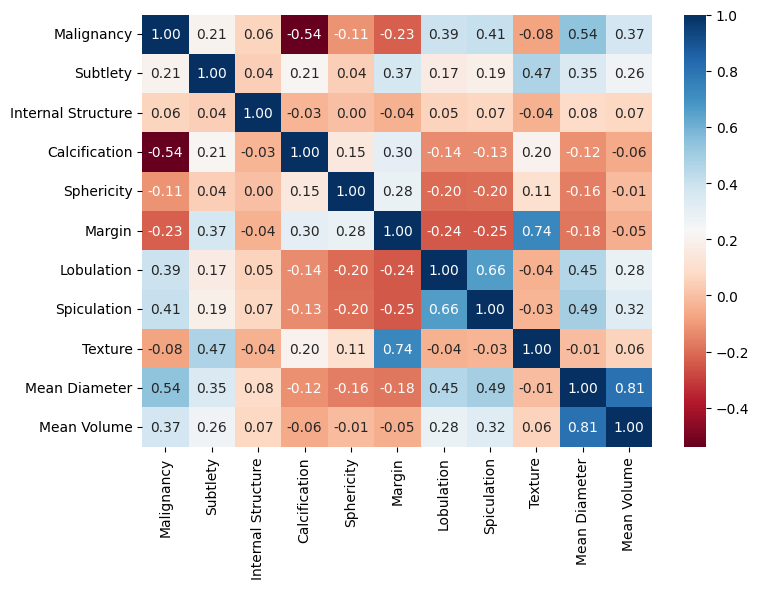

In [37]:
divergent_cmap = 'RdBu'

nodule_df = pd.read_csv(nodule_df_path)[["malignancy_consensus", "subtlety_consensus", "internalStructure_consensus", "calcification_consensus", "sphericity_consensus", "margin_consensus", "lobulation_consensus", "spiculation_consensus", "texture_consensus", "ann_mean_diameter", "ann_mean_volume"]]


# excluded:
# internalStructure_consensus

"""
new order of calcification:
1. abscent
2. non-central
3. central
4. solid
5. laminated
6. popcorn
"""
calcification_mapping = {6:1, 1:6, 2:5, 3:4, 4:2, 5:3}

nodule_df["calcification_consensus"] = nodule_df["calcification_consensus"].map(calcification_mapping)

# rename columns
nodule_df.columns = [col.replace('_consensus', '').capitalize() for col in nodule_df.columns]
nodule_df = nodule_df.rename(columns={"Ann_mean_diameter": "Mean Diameter", "Ann_mean_volume": "Mean Volume", "Internalstructure": "Internal Structure"})

# plot a correlation heatmap
sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(8, 6))
sns.heatmap(nodule_df.corr(method="pearson"), annot=True, fmt=".2f", cmap=divergent_cmap, cbar=True)
plt.tight_layout()
plt.savefig(f'{plots_path}/nodule_correlation_heatmap.png')
plt.show()

## Training Fold Results Plot

In [14]:
# TOOD ADD THE VISUALISE FOLD PLOT FROM visualisation.py file!

## Model Performance Trend for different context windows plot

In [15]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def get_results_df(experiment_ids: list[str]) -> pd.DataFrame:
    local_user = "newuser"
    results = {}
    for e in experiment_ids:
        local_exp_path = f"/Users/{local_user}/Documents/ITU/master_thesis/hpc/jobs/{e}"
        with open(f"{local_exp_path}/run_{e}.json") as f:
            config = json.load(f)
        results[e] = config

    # get aggregated results from all folds
    dataframes = []
    for exp in experiment_ids:
        info = exp.split("_")
        context = info[0]
        dimensionality = info[1]
        all_fold_results = {
            "auc_filtered": [],
            "auc_ovr": [],
            "mae": [],
            "mse": [],
            "cwce": [],
            "binary_accuracy": [],
        }
        for fold in results[exp]["fold_results"]:
            # TODO use the metrics for the best loss
            best_loss_epoch = fold["best_loss_epoch"] - 1 # saved as 1-indexed
            # best_loss_epoch = -1 # use the last epoch

            val_auc_filtered = fold["val_AUC_filtered"][best_loss_epoch]
            val_auc_ovr = fold["val_AUC_ovr"][best_loss_epoch]
            val_mae = fold["val_maes"][best_loss_epoch]
            val_mse = fold["val_mses"][best_loss_epoch]
            val_cwce = fold["val_cwces"][best_loss_epoch]
            val_accuracy = fold["val_binary_accuracies"][best_loss_epoch]

            all_fold_results["auc_filtered"].append(val_auc_filtered)
            all_fold_results["auc_ovr"].append(val_auc_ovr)
            all_fold_results["mae"].append(val_mae)
            all_fold_results["mse"].append(val_mse)
            all_fold_results["cwce"].append(val_cwce)
            all_fold_results["binary_accuracy"].append(val_accuracy)

        agg_results = {}
        for k, v in all_fold_results.items():
            agg_results[k] = context, dimensionality, np.mean(v), np.std(v)

        results_df = pd.DataFrame.from_dict(agg_results, orient="index", columns=["context", "dim", "mean", "std"])
        dataframes.append(results_df)

    results_df = pd.concat(dataframes).reset_index().rename(columns={"index": "metric"})
    return results_df

experiments_25D = [
    "c20_25D_2411_1631",
    "c30_25D_2411_1543",
    "c40_25D_2411_1640",
    "c50_25D_2411_1812",
    "c60_25D_2411_1641",
    "c70_25D_2411_1705",
]
experiments_3D = [
    "c20_3D_2511_0013",
    "c30_3D_2411_1947",
    "c40_3D_2511_1536",
    "c50_3D_2411_1831",
    "c60_3D_2511_2027",
    "c70_3D_2411_1824",
]

agg_results_25D = get_results_df(experiments_25D)
agg_results_3D = get_results_df(experiments_3D)

print("25D")
display(agg_results_25D)

print("3D")
display(agg_results_3D)

25D


,metric,context,dim,mean,std
0,auc_filtered,c20,25D,0.914806,0.017861
1,auc_ovr,c20,25D,0.715784,0.020353
2,mae,c20,25D,0.524977,0.027898
3,mse,c20,25D,0.651111,0.042262
4,cwce,c20,25D,0.345971,0.046392
5,binary_accuracy,c20,25D,0.799619,0.014946
6,auc_filtered,c30,25D,0.911464,0.012075
7,auc_ovr,c30,25D,0.725371,0.015695
8,mae,c30,25D,0.500812,0.034704
9,mse,c30,25D,0.616258,0.058046


3D


,metric,context,dim,mean,std
0,auc_filtered,c20,3D,0.916607,0.027119
1,auc_ovr,c20,3D,0.731427,0.022429
2,mae,c20,3D,0.493141,0.020077
3,mse,c20,3D,0.593317,0.044254
4,cwce,c20,3D,0.341266,0.015584
5,binary_accuracy,c20,3D,0.804069,0.024199
6,auc_filtered,c30,3D,0.903002,0.025152
7,auc_ovr,c30,3D,0.729291,0.018351
8,mae,c30,3D,0.475882,0.030650
9,mse,c30,3D,0.587947,0.069957


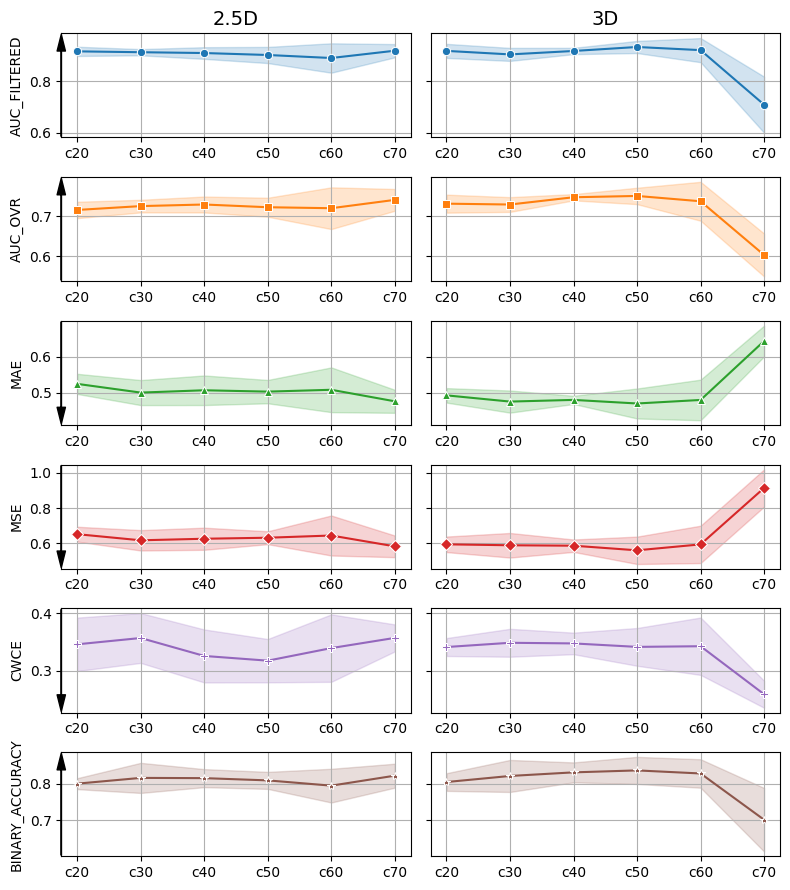

In [16]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

def performance_trend_plot(agg_results_25D: pd.DataFrame, agg_results_3D: pd.DataFrame, save_path: str | None = None):
    n_metrics = agg_results_25D["metric"].nunique()
    _, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(8, 9), sharey="row")

    markers = ['o', 's', '^', 'D', 'P', '*']
    colors = sns.color_palette("tab10")

    for i, metric in enumerate(agg_results_25D["metric"].unique()):
        metric_25D = agg_results_25D[agg_results_25D["metric"] == metric]
        metric_3D = agg_results_3D[agg_results_3D["metric"] == metric]

        # 25D
        ax = axes[i, 0]
        if i == 0: # first row
            ax.set_title("2.5D", fontsize=14)

        sns.lineplot(x="context", y="mean", data=metric_25D, ax=ax, marker=markers[i], color=colors[i])
        ax.fill_between(
            x=metric_25D["context"],
            y1=metric_25D["mean"] - metric_25D["std"],
            y2=metric_25D["mean"] + metric_25D["std"],
            color=colors[i],
            alpha=0.2,
        )
        ax.set_ylabel(metric.upper())
        ax.set_xlabel("")
        ax.grid(True)


        # 3D
        ax = axes[i, 1]
        if i == 0: # first row
            ax.set_title("3D", fontsize=14)

        sns.lineplot(x="context", y="mean", data=metric_3D, ax=ax, marker=markers[i], color=colors[i])
        ax.fill_between(
            metric_3D["context"],
            metric_3D["mean"] - metric_3D["std"],
            metric_3D["mean"] + metric_3D["std"],
            color=colors[i],
            alpha=0.2,
        )
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.grid(True)

    for i, ax in enumerate(axes.flatten()):
        if i % 2 == 0:
            if i in [0, 2, 10]:
                # arrow points up
                ax.annotate('', xy=(0, 1), xytext=(0, 0),
                    arrowprops=dict(facecolor='black', shrink=0.01, width=.2, headwidth=6),
                    color='black', xycoords='axes fraction', textcoords='axes fraction',
                    rotation=90, va='center', ha='right')
            else:
                # arrow points down
                ax.annotate('', xy=(0, 0), xytext=(0, 1),
                    arrowprops=dict(facecolor='black', shrink=0.01, width=.2, headwidth=6),
                    color='black', xycoords='axes fraction', textcoords='axes fraction',
                    rotation=90, va='center', ha='right')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

performance_trend_plot(agg_results_25D, agg_results_3D, save_path=f"{plots_path}/performance_trend_plot.png")

25D Masked


,metric,context,dim,mean,std
0,auc_filtered,c30,25D,0.648905,0.051153
1,auc_ovr,c30,25D,0.565404,0.031742
2,mae,c30,25D,0.675881,0.029131
3,mse,c30,25D,0.973987,0.041271
4,cwce,c30,25D,0.249271,0.034323
5,binary_accuracy,c30,25D,0.638862,0.035996
6,auc_filtered,c40,25D,0.540929,0.074876
7,auc_ovr,c40,25D,0.509821,0.020537
8,mae,c40,25D,0.673538,0.019773
9,mse,c40,25D,0.968486,0.035648


3D Masked


,metric,context,dim,mean,std
0,auc_filtered,c30,3D,0.576197,0.085858
1,auc_ovr,c30,3D,0.517623,0.035431
2,mae,c30,3D,0.676815,0.007267
3,mse,c30,3D,0.977230,0.021978
4,cwce,c30,3D,0.234784,0.024276
5,binary_accuracy,c30,3D,0.638862,0.035996
6,auc_filtered,c40,3D,0.651241,0.096574
7,auc_ovr,c40,3D,0.567202,0.018712
8,mae,c40,3D,0.675637,0.020921
9,mse,c40,3D,0.973384,0.039688


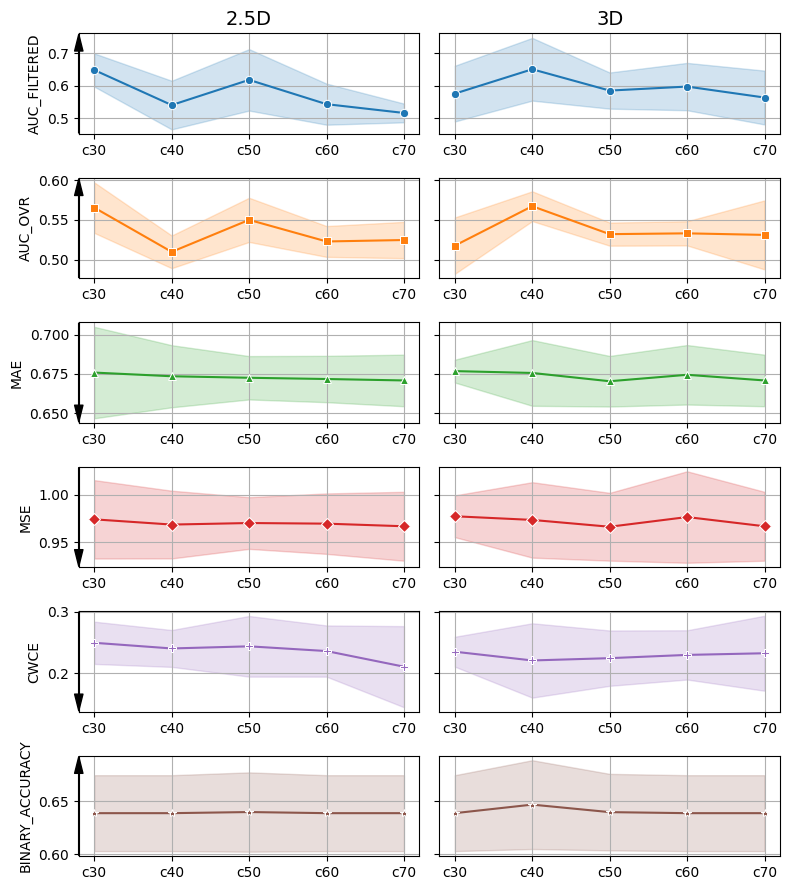

In [17]:
# FOR MASKED EXPERIMENTS
experiments_25D_masked = [
    "c30_25D_2911_1126",
    "c40_25D_2811_2153",
    "c50_25D_2811_2112",
    "c60_25D_2811_2111",
    "c70_25D_2811_2106"
]
experiments_3D_masked = [
    "c30_3D_2911_1118",
    "c40_3D_0112_2132",
    "c50_3D_2911_1631",
    "c60_3D_2911_1630",
    "c70_3D_2911_1131",
]

agg_results_25D_masked = get_results_df(experiments_25D_masked)
agg_results_3D_masked = get_results_df(experiments_3D_masked)

print("25D Masked")
display(agg_results_25D_masked)

print("3D Masked")
display(agg_results_3D_masked)

performance_trend_plot(agg_results_25D_masked, agg_results_3D_masked, save_path=f"{plots_path}/performance_trend_plot_masked.png")

**NOTE**: the errorbar in the plot above is 1 whole std both above and below the line.

# How noisy are the annotations labels?

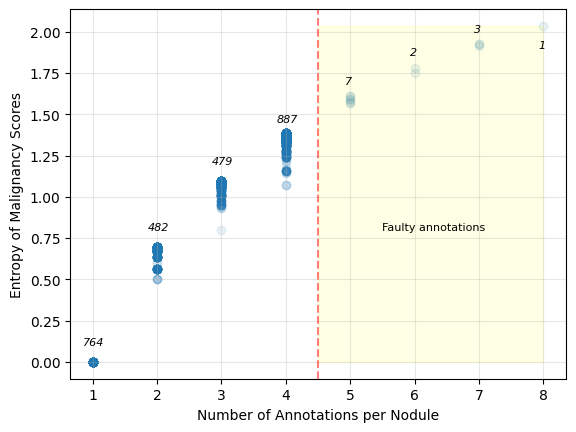

In [18]:
import ast
import numpy as np
from scipy.stats import entropy
from collections import Counter

nodule_df = pd.read_csv(nodule_df_path)
# TODO use the color to represent the number of annotations

malignancy_scores = nodule_df[
    f"malignancy_scores"
].apply(ast.literal_eval)

std = [np.std(x) for x in malignancy_scores]
ent = [entropy(x) for x in malignancy_scores]
n_annotations = [len(x) for x in malignancy_scores]
c_annotations = Counter(n_annotations)

plt.scatter(n_annotations, ent, alpha=0.1)
plt.xlabel("Number of Annotations per Nodule")
plt.ylabel("Entropy of Malignancy Scores")
plt.grid(alpha=0.3)
plt.axvline(x=4.5, color='r', linestyle='--', alpha=0.5, label="Cut-off")
plt.text(5.5, 0.8, "Faulty annotations", fontsize=8)
plt.fill_between([4.5, 8], 0, max(ent), color='yellow', alpha=0.1)

# Annotate the number of nodules with a specific number of annotations
size = 8
color = "black"
weight = "bold"
style = "italic"
plt.text(0.85, 0.10, f"{c_annotations[1]}", fontsize=size, style=style)
plt.text(1.85, 0.80, f"{c_annotations[2]}", fontsize=size, style=style)
plt.text(2.85, 1.20, f"{c_annotations[3]}", fontsize=size, style=style)
plt.text(3.85, 1.45, f"{c_annotations[4]}", fontsize=size, style=style)
plt.text(4.92, 1.68, f"{c_annotations[5]}", fontsize=size, style=style)
plt.text(5.92, 1.86, f"{c_annotations[6]}", fontsize=size, style=style)
plt.text(6.92, 2, f"{c_annotations[7]}", fontsize=size, style=style)
plt.text(7.92, 1.90, f"{c_annotations[8]}", fontsize=size, style=style)
plt.show()

# sns.jointplot(x=n_annotations, y=std)
# plt.xlabel("Number of Annotations")
# plt.ylabel("Standard Deviation")
# plt.show()

# Embedding plots

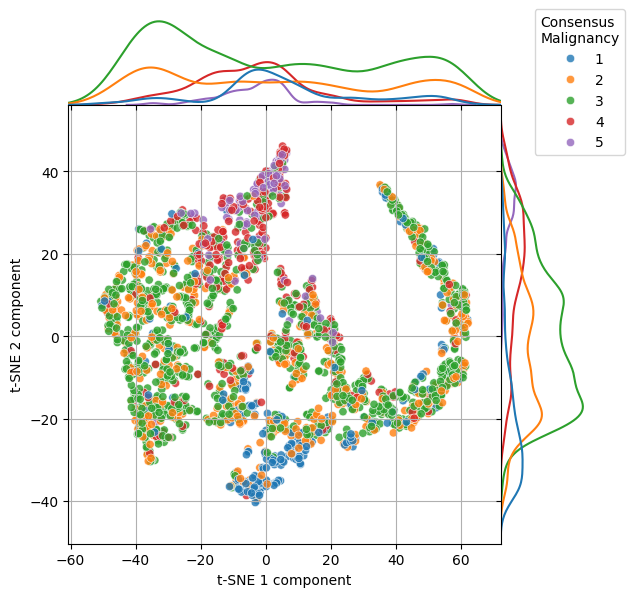

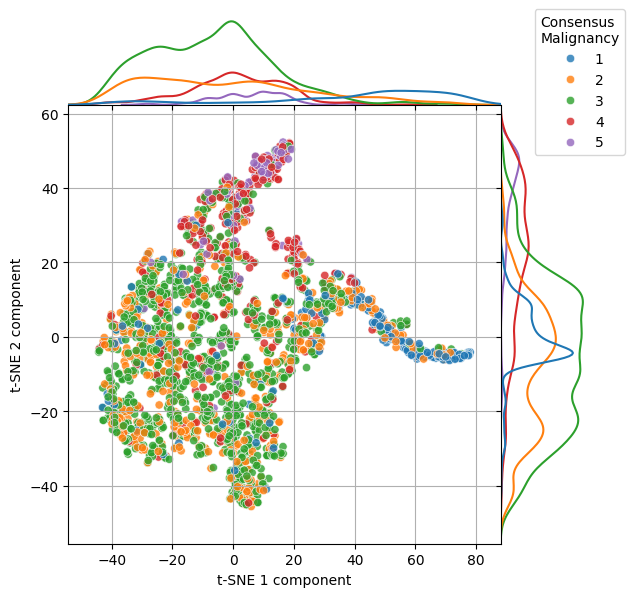

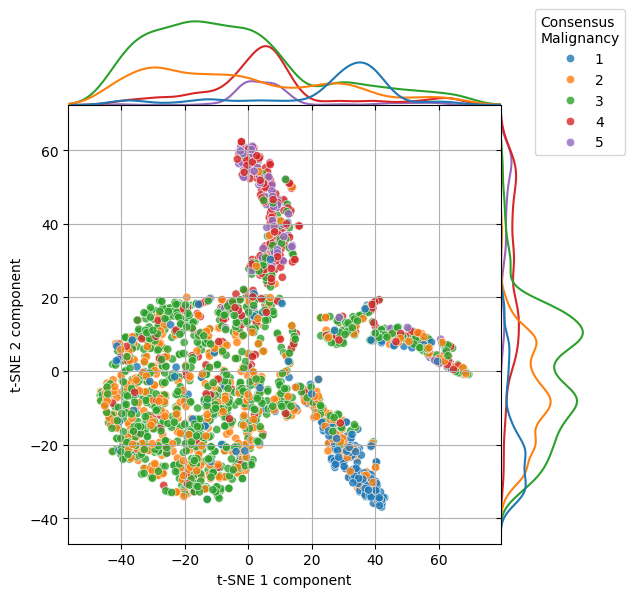

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# color_pallete = "RdYlBu"
# color_pallete = "YlGnBu"
color_pallete = "tab10"
nodule_df = pd.read_csv(nodule_processed_df_path)

# Plot params:
ratio = 5 # ratio of jointplot to scatterplot
height = 6 # height of the jointplot
padding = 10 # padding between scatterplot and jointplot
marginal_kws = {
   "fill": False,
   "bw_method": 0.2, # make the marginals more pointy
}

def plot_embeddings(embeddings_path: str) -> None:
    embeddings_25d = pd.read_csv(embeddings_path)
    embeddings_25d = pd.merge(embeddings_25d, nodule_df, on="nodule_id")

    # or "crest" color pallete
    g = sns.jointplot(data=embeddings_25d, x="x_embed", y="y_embed", hue="malignancy_consensus", alpha=0.8, palette=color_pallete, kind="scatter", height=height, ratio=ratio, space=0, marginal_kws=marginal_kws)
    x_min, x_max = embeddings_25d["x_embed"].min(), embeddings_25d["x_embed"].max()
    y_min, y_max = embeddings_25d["y_embed"].min(), embeddings_25d["y_embed"].max()

    plt.xlim(x_min - padding, x_max + padding)
    plt.xlabel("t-SNE 1 component")
    plt.ylabel("t-SNE 2 component")
    plt.ylim(y_min - padding, y_max + padding)

    plt.legend().remove()
    g.figure.legend(title="Consensus\nMalignancy", bbox_to_anchor=(1.05, 1))

    plt.grid(True)
    plt.show()

# C30 25D
plot_embeddings("model/embeddings/c30_25D_2411_1543/fold0/embeddings_df.csv")

# C50 25D
plot_embeddings("model/embeddings/c50_25D_2411_1812/fold0/embeddings_df.csv")

# C70 25D
plot_embeddings("model/embeddings/c70_25D_2411_1705/fold0/embeddings_df.csv")

## Holdout set benchmark table and plot 
benchmarks are computed with the `model/benchmark.py` script

In [20]:
benchmarks = pd.read_csv("model/model_benchmark_results.csv").rename(columns={"Unnamed: 0": "model"}).set_index("model")

print(benchmarks[['binary_accuracy', 'AUC_filtered', 'mae', 'mse', 'cwce']].round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & binary_accuracy & AUC_filtered & mae & mse & cwce \\
model &  &  &  &  &  \\
\midrule
c30_25D_2411_1543 & 0.802000 & 0.875000 & 0.576000 & 0.753000 & 0.342000 \\
c50_25D_2411_1812 & 0.790000 & 0.848000 & 0.598000 & 0.804000 & 0.314000 \\
c70_25D_2411_1705 & 0.716000 & 0.840000 & 0.624000 & 0.830000 & 0.364000 \\
c30_3D_2411_1947 & 0.765000 & 0.870000 & 0.568000 & 0.731000 & 0.394000 \\
c50_3D_2411_1831 & 0.796000 & 0.890000 & 0.546000 & 0.672000 & 0.358000 \\
c70_3D_2411_1824 & 0.784000 & 0.780000 & 0.708000 & 1.026000 & 0.272000 \\
\bottomrule
\end{tabular}

